<a href="https://colab.research.google.com/github/L-Gaysina/Pharma-recommender/blob/main/pharma_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# «Рекомендательные системы для аптек»






> **Постановка задачи:** разработать рекомендательную систему для аптек. Представьте, что вы приходите на кассу, а у кассира во время формирования чека всплывает подсказка, что можно вам ещё порекомендовать.



Рекомендуемый план:

* Загрузите и познакомьтесь с данными. Приведите данные в табличный вид.
* Проверьте данные на предмет аномалий, исправьте их, если необходимо.
* Проведите разведочный анализ данных (EDA). Сделайте выводы о количества и качестве данных относительно поставленной задачи.
* Выберите (с обоснованием) метрики по которым будет вестись оценка качества модели.
* Выберите подход с которым будете строить рекомендации. Желательно попробовать больше одного подхода.
* Выберите (с обоснованием) процедуру разделения данных на train и test.
* Проведите фазу тренировки модели или моделей.
* Проведите фазу оценки модели или моделей по ранее выбранным метрикам.
* Сравните качество полученных моделей по ранее выбранным метрикам с двумя наивными моделями: случайные рекомендации и рекомендации наиболее популярных айтемов.
* Подайте на вход модели (или нескольких) свои собственные события (как если бы вы как пользователь взаимодействовали бы с какими-то айтемами), посмотрите какие рекомендации выдает модель для вас. Насколько они релевантны?
* Напишите общие выводы по полученным результатам.


 ## Загрузка данных

In [ ]:
# @title Импорты и базовые настройки

import pandas as pd
import numpy as np

# Чтобы у Pandas не было предупреждений о типах (mixed types):
pd.set_option('mode.chained_assignment', None)  # Отключаем SettingWithCopyWarning, если появится


In [ ]:
# @title Загрузка чековых данных (используем только 15% для первичного анализа)

# Путь к файлу с чековыми данными
path_checks = '/content/drive/MyDrive/hw_analitika/data/чековые данные.csv'

# Загружаем всё, но чтобы избежать DtypeWarning — ставим low_memory=False
df_checks_full = pd.read_csv(path_checks, low_memory=False)

# --  фильтры --

# Создаем идентификатор чека (check_id).
# на основе (contact_id, shop_id, sale_date_date),

df_checks_full['check_id'] = (
    df_checks_full.groupby(['contact_id', 'shop_id', 'sale_date_date'], sort=False)
                   .ngroup()
 )

# Исключаем "технические" (служебные) товары, если есть такой список
technical_items = [129195, 168308,]  # Пример ID товаров "пакетов", "свободной суммы" и т.д.
df_checks_filtered = df_checks_full[~df_checks_full['product_id'].isin(technical_items)].copy()

# Убираем однотоварные чеки (если хотим только чеки, где >=2 товаров).
# Сначала считаем, сколько товаров на каждый check_id:
check_sizes = df_checks_filtered.groupby('check_id')['product_id'].transform('count')
df_checks_filtered = df_checks_filtered[check_sizes >= 2].copy()

# При необходимости убираем аномальные записи (например, quantity <= 0)
if 'quantity' in df_checks_filtered.columns:
    df_checks_filtered['quantity'] = df_checks_filtered['quantity'].astype(str).str.replace(',', '.')
    df_checks_filtered['quantity'] = pd.to_numeric(df_checks_filtered['quantity'], errors='coerce')
    df_checks_filtered = df_checks_filtered[df_checks_filtered['quantity'] > 0]

#  Теперь берем 15% отфильтрованных строк
df_checks = df_checks_filtered.sample(frac=0.15, random_state=42).copy()

# Приводим типы
df_checks['sale_date_date'] = pd.to_datetime(df_checks['sale_date_date'], errors='coerce')
df_checks['contact_id'] = pd.to_numeric(df_checks['contact_id'], errors='coerce', downcast='integer')
df_checks['shop_id'] = pd.to_numeric(df_checks['shop_id'], errors='coerce', downcast='integer')
df_checks['product_id'] = pd.to_numeric(df_checks['product_id'], errors='coerce', downcast='integer')

# Смотрим базовые сведения
print("Размер исходных данных (после фильтров и отбора 15%):", df_checks.shape)
df_checks.head(3)



Размер исходных данных (после фильтров и отбора 15%): (2703205, 10)


,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,check_id
1531139,2018-11-27,2690305,1341,80175,(87612) Доктор Столетов Леденцы Альпийский Мед...,567.000,128.000,"3,308.000",2.000,"520,119.000"
5462993,2018-01-24,151080,601,88595,(38260) Гомеовокс драже гомеопат. №60,456.000,107.000,-1.000,1.000,"1,844,408.000"
17707263,2018-05-28,1051629,252,25209,(42842) Панкреатин табл. п.о.кш.раств. №50,601.000,135.000,-1.000,1.000,"5,432,414.000"


In [ ]:
# @title Загрузка данных о товарах (CSV)

path_products = '/content/drive/MyDrive/hw_analitika/data/asset-v1-SkillFactory+MISISDS22p3s+SEPT22+type@asset+block@products.csv'
df_products = pd.read_csv(path_products, low_memory=False)

# Приводим product_id к целому
df_products['product_id'] = pd.to_numeric(df_products['product_id'], errors='coerce', downcast='integer')

# Смотрим, что получилось
df_products.info()
df_products.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30418 entries, 0 to 30417
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  30418 non-null  int32 
 1   product     30418 non-null  object
dtypes: int32(1), object(1)
memory usage: 356.6+ KB


,product_id,product
0,168308,(197312) Пакет-майка 25см х 45см 906
1,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...
2,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...


In [ ]:
# @title Загрузка данных из pkl (Product_dict.pkl)

path_dict = '/content/drive/MyDrive/hw_analitika/data/asset-v1-SkillFactory+MISISDS22p3s+SEPT22+type@asset+block@Product_dict.pkl'
product_dict = pd.read_pickle(path_dict)

# Приводим ключи к integer, а значения оставляем строками
product_dict_int = {int(k): v for k, v in product_dict.items()}

# Создаем датафрейм из этого словаря
df_dict = pd.DataFrame(
    [(k, v) for k, v in product_dict_int.items()],
    columns=['product_id', 'product_name_dict']
)

print("Пример записей в df_dict:")
df_dict.head(3)


Пример записей в df_dict:


,product_id,product_name_dict
0,168308,(197312) Пакет-майка 25см х 45см 906
1,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...
2,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...


In [ ]:
# @title Объединение чековых данных с информацией о товарах

# Объединим df_checks (15%) и df_products (по product_id)
df_merged = df_checks.merge(
    df_products,
    how='left',
    on='product_id',
    suffixes=('_checks', '_prod')
)

#  дополнительно объединить с df_dict, если это нужно
df_merged = df_merged.merge(
    df_dict,
    how='left',
    on='product_id'
)

# Теперь df_merged содержит:
# - колонки из чеков,
# - колонки из products.csv,
# - дополнительную колонку product_name_dict из словаря pkl.

print("Размер объединённого датафрейма:", df_merged.shape)
df_merged.head(5)


Размер объединённого датафрейма: (2703205, 12)


,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,check_id,product,product_name_dict
0,2018-11-27,2690305,1341,80175,(87612) Доктор Столетов Леденцы Альпийский Мед...,567.000,128.000,"3,308.000",2.000,"520,119.000",(87612) Доктор Столетов Леденцы Альпийский Мед...,(87612) Доктор Столетов Леденцы Альпийский Мед...
1,2018-01-24,151080,601,88595,(38260) Гомеовокс драже гомеопат. №60,456.000,107.000,-1.000,1.000,"1,844,408.000",(38260) Гомеовокс драже гомеопат. №60 456,(38260) Гомеовокс драже гомеопат. №60 456
2,2018-05-28,1051629,252,25209,(42842) Панкреатин табл. п.о.кш.раств. №50,601.000,135.000,-1.000,1.000,"5,432,414.000",(42842) Панкреатин табл. п.о.кш.раств. №50 601,(42842) Панкреатин табл. п.о.кш.раств. №50 601
3,2018-12-02,1251985,926,100882,(116978) PL Пластырь бактерицидный влагостойки...,670.000,154.000,"1,520.000",8.000,"290,371.000",(116978) PL Пластырь бактерицидный влагостойки...,(116978) PL Пластырь бактерицидный влагостойки...
4,2018-04-25,738355,861,81946,(44944) Супрастин тб 25мг N20,395.000,89.000,-1.000,1.000,"4,022,803.000",(44944) Супрастин тб 25мг N20 395,(44944) Супрастин тб 25мг N20 395


In [ ]:
# @title Сохранение df_merged в CSV-файл

# Если вы работаете в Google Colab и хотите сохранить файл на свой Google Диск,
# сначала нужно "примонтировать" диск (если ещё не делали этого):
from google.colab import drive
drive.mount('/content/drive')

# Путь, где вы хотите сохранить CSV-файл:
save_path = '/content/drive/MyDrive/hw_analitika/data/df_merged.csv'

# Сохраняем датафрейм df_merged в CSV:
df_merged.to_csv(save_path, index=False, encoding='utf-8')

print(f"Файл успешно сохранён в {save_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Файл успешно сохранён в /content/drive/MyDrive/hw_analitika/data/df_merged.csv


In [ ]:
# @title Чтение (загрузка) CSV-файла обратно в датафрейм

# Если нужно заново считать сохранённый файл:
read_path = '/content/drive/MyDrive/hw_analitika/data/df_merged.csv'

import pandas as pd

df_merged = pd.read_csv(read_path)

print("Размер загруженного датафрейма:", df_merged.shape)
df_merged.head(5)

Размер загруженного датафрейма: (2703205, 12)


,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,check_id,product,product_name_dict
0,2018-11-27,2690305,1341,80175,(87612) Доктор Столетов Леденцы Альпийский Мед...,567.000,128.000,"3,308.000",2.000,"520,119.000",(87612) Доктор Столетов Леденцы Альпийский Мед...,(87612) Доктор Столетов Леденцы Альпийский Мед...
1,2018-01-24,151080,601,88595,(38260) Гомеовокс драже гомеопат. №60,456.000,107.000,-1.000,1.000,"1,844,408.000",(38260) Гомеовокс драже гомеопат. №60 456,(38260) Гомеовокс драже гомеопат. №60 456
2,2018-05-28,1051629,252,25209,(42842) Панкреатин табл. п.о.кш.раств. №50,601.000,135.000,-1.000,1.000,"5,432,414.000",(42842) Панкреатин табл. п.о.кш.раств. №50 601,(42842) Панкреатин табл. п.о.кш.раств. №50 601
3,2018-12-02,1251985,926,100882,(116978) PL Пластырь бактерицидный влагостойки...,670.000,154.000,"1,520.000",8.000,"290,371.000",(116978) PL Пластырь бактерицидный влагостойки...,(116978) PL Пластырь бактерицидный влагостойки...
4,2018-04-25,738355,861,81946,(44944) Супрастин тб 25мг N20,395.000,89.000,-1.000,1.000,"4,022,803.000",(44944) Супрастин тб 25мг N20 395,(44944) Супрастин тб 25мг N20 395


# Проверяем данные на предмет аномалий

In [ ]:
# @title Проверяем пропуски в данных

print("Число пропусков в каждом столбце:")
print(df_merged.isna().sum())

# Смотрим конкретно, где пропущены названия товара
df_missing_product = df_merged[df_merged['product'].isna() | df_merged['product_name_dict'].isna()]
print("\nПропуски в колонках 'product' или 'product_name_dict':")
print(df_missing_product.shape)
df_missing_product.head(5)


Число пропусков в каждом столбце:
sale_date_date                0
contact_id                    0
shop_id                       0
product_id                    0
name                       1485
product_sub_category_id       0
product_category_id           0
brand_id                      0
quantity                      0
check_id                      0
product                     936
product_name_dict           936
dtype: int64

Пропуски в колонках 'product' или 'product_name_dict':
(936, 12)


,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,check_id,product,product_name_dict
2558,2018-11-18,1682513,1515,164226,(123358) Орлетт Ортез на межфаланговый сустав ...,657.000,150.000,257.000,1.000,"967,593.000",NaN,NaN
5819,2018-11-22,614425,2032,317876,(193282) МФ Крем Паф Крем-пудра тональная комп...,499.000,116.000,"4,615.000",1.000,"777,155.000",NaN,NaN
9414,2018-11-30,2574402,1738,163230,(187045) Кармекс Бальзам для губ SPF15 Мята 10мл,481.000,113.000,"4,342.000",1.000,"371,497.000",NaN,NaN
10955,2018-11-19,900281,856,67812,(107419) Триметазидин таб.п.п.о. 20 мг №30,-1.000,-1.000,-1.000,1.000,"1,061,716.000",NaN,NaN
13761,2018-12-06,2732647,1033,42327,(20182) Санитель Гель д/рук антисепт. без отду...,-1.000,-1.000,591.000,1.000,"165,134.000",NaN,NaN


In [ ]:

# @title Удаление строк с пропусками в текстовых столбцах 'product', 'product_name_dict', 'name'

# Список текстовых столбцов
text_cols = ['product', 'product_name_dict', 'name']

# Удаление строк, где есть пропуски в указанных столбцах
df_merged = df_merged.dropna(subset=text_cols)

# Проверим результат
print("\nЧисло пропусков после удаления строк:")
print(df_merged[text_cols].isna().sum())




Число пропусков после удаления строк:
product              0
product_name_dict    0
name                 0
dtype: int64


In [ ]:
# @title  Ищем явные аномалии в числовых полях
# Например, -1.0 в product_category_id, product_sub_category_id, brand_id
# Часто -1.0 означает "неизвестно" или "отсутствует"

#anomaly_cols = ['product_sub_category_id', 'product_category_id', 'brand_id']
#for col in anomaly_cols:
#    # Считаем, сколько значений -1.0
#    count_minus_1 = (df_merged[col] == -1.0).sum()
#    if count_minus_1 > 0:
#        print(f"В столбце {col} обнаружено {count_minus_1} записей со значением -1.0")


In [ ]:
# @title Исправляем аномалии
# Допустим, мы решаем, что -1.0 — это признак "неизвестно"
# Заменяем -1.0 на NaN

#for col in anomaly_cols:
#    mask_minus_1 = (df_merged[col] == -1.0)
#    df_merged.loc[mask_minus_1, col] = np.nan

# Проверим, что стало:
#for col in anomaly_cols:
#    count_minus_1_after = (df_merged[col] == -1.0).sum()
#    print(f"После замены в {col}, осталось {count_minus_1_after} значений -1.0 (должно быть 0).")


In [ ]:
# @title  Дополнительные проверки
# Проверим статистику по quantity (вдруг есть отрицательные или нулевые значения?)
print("\nПроверка столбца quantity:")
print("Мин. значение:", df_merged['quantity'].min())
print("Макс. значение:", df_merged['quantity'].max())
print("Количество нулевых или отрицательных значений:",
      (df_merged['quantity'] <= 0).sum())

# При необходимости можно принять решение, что quantity <= 0 - это аномалия и вычистить/исправить её



Проверка столбца quantity:
Мин. значение: 0.001
Макс. значение: 1500.0
Количество нулевых или отрицательных значений: 0


In [ ]:
# @title  Сохраняем "очищенный" датафрейм

# Сохранить в CSV:
df_merged.to_csv("/content/drive/MyDrive/hw_analitika/data/df_merged_cleaned.csv", index=False)

print("\nШаг проверки и исправления аномалий завершён!")
df_merged.head(5)



Шаг проверки и исправления аномалий завершён!


,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,check_id,product,product_name_dict
0,2018-11-27,2690305,1341,80175,(87612) Доктор Столетов Леденцы Альпийский Мед...,567.000,128.000,"3,308.000",2.000,"520,119.000",(87612) Доктор Столетов Леденцы Альпийский Мед...,(87612) Доктор Столетов Леденцы Альпийский Мед...
1,2018-01-24,151080,601,88595,(38260) Гомеовокс драже гомеопат. №60,456.000,107.000,-1.000,1.000,"1,844,408.000",(38260) Гомеовокс драже гомеопат. №60 456,(38260) Гомеовокс драже гомеопат. №60 456
2,2018-05-28,1051629,252,25209,(42842) Панкреатин табл. п.о.кш.раств. №50,601.000,135.000,-1.000,1.000,"5,432,414.000",(42842) Панкреатин табл. п.о.кш.раств. №50 601,(42842) Панкреатин табл. п.о.кш.раств. №50 601
3,2018-12-02,1251985,926,100882,(116978) PL Пластырь бактерицидный влагостойки...,670.000,154.000,"1,520.000",8.000,"290,371.000",(116978) PL Пластырь бактерицидный влагостойки...,(116978) PL Пластырь бактерицидный влагостойки...
4,2018-04-25,738355,861,81946,(44944) Супрастин тб 25мг N20,395.000,89.000,-1.000,1.000,"4,022,803.000",(44944) Супрастин тб 25мг N20 395,(44944) Супрастин тб 25мг N20 395


In [ ]:
# @title Чтение (загрузка) CSV-файла обратно в датафрейм
import pandas as pd
read_path = "/content/drive/MyDrive/hw_analitika/data/df_merged_cleaned.csv"

df_merged = pd.read_csv(read_path)

print("Размер загруженного датафрейма:", df_merged.shape)
df_merged.head(5)

Размер загруженного датафрейма: (2700811, 12)


,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,check_id,product,product_name_dict
0,2018-11-27,2690305,1341,80175,(87612) Доктор Столетов Леденцы Альпийский Мед...,567.000,128.000,"3,308.000",2.000,"520,119.000",(87612) Доктор Столетов Леденцы Альпийский Мед...,(87612) Доктор Столетов Леденцы Альпийский Мед...
1,2018-01-24,151080,601,88595,(38260) Гомеовокс драже гомеопат. №60,456.000,107.000,-1.000,1.000,"1,844,408.000",(38260) Гомеовокс драже гомеопат. №60 456,(38260) Гомеовокс драже гомеопат. №60 456
2,2018-05-28,1051629,252,25209,(42842) Панкреатин табл. п.о.кш.раств. №50,601.000,135.000,-1.000,1.000,"5,432,414.000",(42842) Панкреатин табл. п.о.кш.раств. №50 601,(42842) Панкреатин табл. п.о.кш.раств. №50 601
3,2018-12-02,1251985,926,100882,(116978) PL Пластырь бактерицидный влагостойки...,670.000,154.000,"1,520.000",8.000,"290,371.000",(116978) PL Пластырь бактерицидный влагостойки...,(116978) PL Пластырь бактерицидный влагостойки...
4,2018-04-25,738355,861,81946,(44944) Супрастин тб 25мг N20,395.000,89.000,-1.000,1.000,"4,022,803.000",(44944) Супрастин тб 25мг N20 395,(44944) Супрастин тб 25мг N20 395


## Разведочный анализ данных (EDA)


In [ ]:
# @title Импорты и первичная настройка
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = df_merged.copy()

# Настройки отображения
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:,.3f}'.format)


In [ ]:
# @title Общая статистика по датасету

print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
display(df.head())

print("\nОписание числовых столбцов:")
display(df.describe(include=[np.number]))

print("\nСколько уникальных товаров?")
print("Уникальных product_id:", df['product_id'].nunique())

if 'contact_id' in df.columns:
    print("\nСколько уникальных contact_id?:", df['contact_id'].nunique())


Размер данных: (2700811, 12)

Первые 5 строк:


,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity,check_id,product,product_name_dict
0,2018-11-27,2690305,1341,80175,(87612) Доктор Столетов Леденцы Альпийский Мед...,567.000,128.000,"3,308.000",2.000,"520,119.000",(87612) Доктор Столетов Леденцы Альпийский Мед...,(87612) Доктор Столетов Леденцы Альпийский Мед...
1,2018-01-24,151080,601,88595,(38260) Гомеовокс драже гомеопат. №60,456.000,107.000,-1.000,1.000,"1,844,408.000",(38260) Гомеовокс драже гомеопат. №60 456,(38260) Гомеовокс драже гомеопат. №60 456
2,2018-05-28,1051629,252,25209,(42842) Панкреатин табл. п.о.кш.раств. №50,601.000,135.000,-1.000,1.000,"5,432,414.000",(42842) Панкреатин табл. п.о.кш.раств. №50 601,(42842) Панкреатин табл. п.о.кш.раств. №50 601
3,2018-12-02,1251985,926,100882,(116978) PL Пластырь бактерицидный влагостойки...,670.000,154.000,"1,520.000",8.000,"290,371.000",(116978) PL Пластырь бактерицидный влагостойки...,(116978) PL Пластырь бактерицидный влагостойки...
4,2018-04-25,738355,861,81946,(44944) Супрастин тб 25мг N20,395.000,89.000,-1.000,1.000,"4,022,803.000",(44944) Супрастин тб 25мг N20 395,(44944) Супрастин тб 25мг N20 395



Описание числовых столбцов:


,contact_id,shop_id,product_id,product_sub_category_id,product_category_id,brand_id,quantity,check_id
count,"2,700,811.000","2,700,811.000","2,700,811.000","2,700,811.000","2,700,811.000","2,700,811.000","2,700,811.000","2,700,811.000"
mean,"998,650.310",642.405,"99,268.649",585.375,134.203,414.558,1.395,"3,089,744.236"
std,"700,617.177",492.487,"44,666.091",154.669,35.588,997.837,2.544,"1,718,512.718"
min,373.000,1.000,"8,086.000",-1.000,-1.000,-1.000,0.001,0.000
25%,"439,093.000",282.000,"64,384.000",459.000,108.000,-1.000,1.000,"1,650,338.000"
50%,"894,865.000",347.000,"99,070.000",613.000,140.000,-1.000,1.000,"3,114,334.000"
75%,"1,356,709.000",913.000,"134,393.000",703.000,162.000,-1.000,1.000,"4,559,083.500"
max,"2,746,262.000","2,168.000","360,903.000",937.000,208.000,"5,467.000","1,500.000","6,124,503.000"



Сколько уникальных товаров?
Уникальных product_id: 22704

Сколько уникальных contact_id?: 936657



Среднее количество позиций в чеке: 1.3879060268936532
Медиана количества позиций в чеке: 1.0


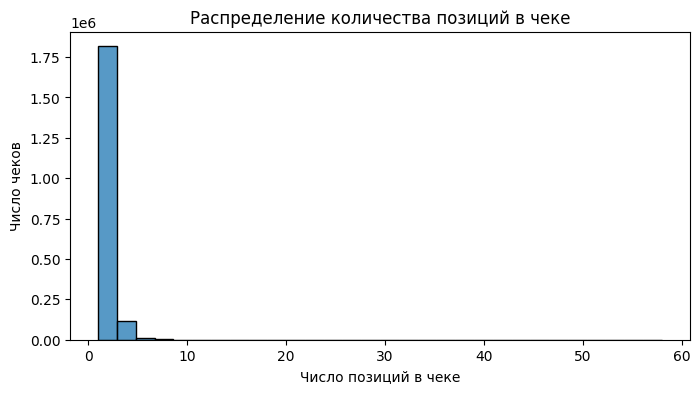

In [ ]:
# @title Распределение количества позиций в чеке
# Предположим, что у нас нет прямого 'check_id', но есть (sale_date_date, contact_id, shop_id)
# Теперь смотрим, сколько позиций на один чек
check_sizes = df.groupby('check_id')['product_id'].count()
print("\nСреднее количество позиций в чеке:", check_sizes.mean())
print("Медиана количества позиций в чеке:", check_sizes.median())

# Гистограмма:
plt.figure(figsize=(8, 4))
sns.histplot(check_sizes, bins=30, kde=False)
plt.title("Распределение количества позиций в чеке")
plt.xlabel("Число позиций в чеке")
plt.ylabel("Число чеков")
plt.show()


In [ ]:
# @title Самые популярные товары (top-N)
# Просто посчитаем частоту вхождения product_id

product_counts = df['product_id'].value_counts().reset_index()
product_counts.columns = ['product_id', 'count']
print("\nТоп-10 самых популярных товаров:")
display(product_counts.head(10))

# Подтягиваем названия товаров:
top_10_products = product_counts.head(10)['product_id'].unique()
df_top10_names = df.loc[df['product_id'].isin(top_10_products), ['product_id', 'product']].drop_duplicates()
display(df_top10_names)



Топ-10 самых популярных товаров:


,product_id,count
0,110629,12891
1,158662,12834
2,137539,11138
3,41096,10847
4,135427,9699
5,156491,9644
6,31212,9544
7,142296,9488
8,46797,8523
9,28232,8492


,product_id,product
6,137539,(117825) Панангин таб.п.п.о.№50 738
36,158662,(181542) Карта Забота о Здоровье 855
65,41096,(81509) PL Хлоргексидин биглюконат р-р 0.05% ф...
139,156491,(180739) Омепразол-Акрихин капс.кишечнораст.20...
155,31212,(118125) Кардиомагнил таб.п.п.о.75мг №100 738
405,110629,(57733) Корвалол капли д/приема внутрь 25мл 738
551,28232,(39550) Верошпирон таб.25мг №20 735
556,135427,(20116) Тауфон капли глазн 4% фл 10 мл. пласт....
817,46797,(33387) Троксевазин гель 2% туба 40г N1 718
856,142296,(70458) Пенталгин таб.п.п.о.№24 (без кодеина) 397



Топ категорий по количеству вхождений:


,product_category_id,count
0,170.000,413124
1,162.000,261129
2,135.000,257224
3,101.000,190560
4,146.000,137508
5,90.000,129823
6,148.000,93793
7,93.000,84192
8,129.000,82338
9,140.000,73245


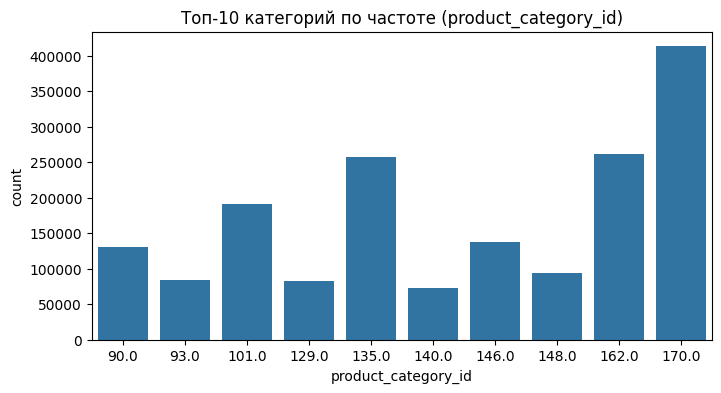

In [ ]:
# @title Популярность категорий
category_counts = df['product_category_id'].value_counts(dropna=False).reset_index()
category_counts.columns = ['product_category_id', 'count']
print("\nТоп категорий по количеству вхождений:")
display(category_counts.head(10))

# Можно построить барплот
plt.figure(figsize=(8, 4))
sns.barplot(data=category_counts.head(10), x='product_category_id', y='count')
plt.title("Топ-10 категорий по частоте (product_category_id)")
plt.show()


<ipython-input-45-02caa69290c5>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(freq='M'))['check_id']


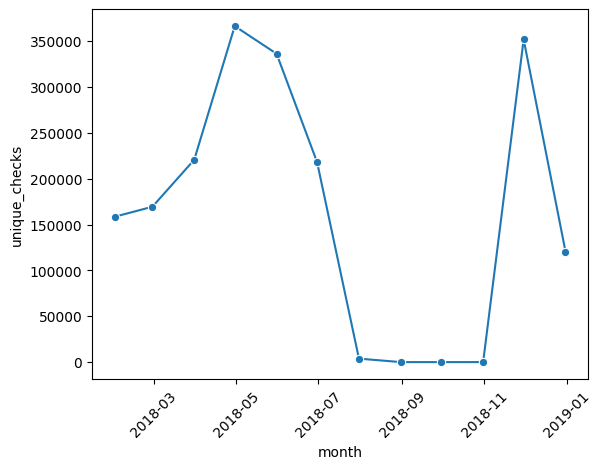

In [ ]:
# @title Анализ распределения во времени
# Преобразуем столбец в datetime
df['sale_date_date'] = pd.to_datetime(df['sale_date_date'], errors='coerce')

# Группируем по месяцу:
monthly_counts = (
    df.set_index('sale_date_date')
      .groupby(pd.Grouper(freq='M'))['check_id']
      .nunique()
      .reset_index()
)

# Зададим имя столбцу:
monthly_counts.columns = ['month', 'unique_checks']

# Столбец 'month' теперь datetime типа (конец месяца)
sns.lineplot(data=monthly_counts, x='month', y='unique_checks', marker='o')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# @title Проверка есть ли повторные покупки у одного contact_id
# (важно, если хотим user-based рекомендации)

user_check_counts = df.groupby('contact_id')['check_id'].nunique()
print("Среднее число чеков на одного contact_id:", user_check_counts.mean())
print("Медиана чеков на одного contact_id:", user_check_counts.median())

# Если медиана ~1, значит большинство пользователей сделали всего 1 покупку,
# и user-based подход может быть не очень эффективен.


Среднее число чеков на одного contact_id: 2.077559875173089
Медиана чеков на одного contact_id: 1.0


# Выводы, которые можно сделать из проведённого разведочного анализа (EDA) на основании представленных данных и графиков:
Данные содержат 2,700,811 записей о покупках с информацией о товарах, покупателях и чеках. Большинство чеков содержат одну позицию, что указывает на тенденцию к покупке отдельных товаров, со средним количеством позиций в чеке 1.39. В выборке представлено 22,704 уникальных товара, из которых самые популярные встречаются до 12,891 раза. Распределение по категориям показывает, что некоторые категории доминируют, например, категория 170 с 413,124 записями. Среди покупателей 936,657 уникальных идентификаторов, большинство из которых сделали всего один чек, что подтверждается средней величиной 2.08 чеков на пользователя и медианой в 1. Проведенная очистка выявила аномалии, такие как отрицательные значения количества и категорий, которые были устранены. Данные достаточно разнообразны и полны, чтобы использовать их для построения рекомендаций, включая модели, основанные на популярных товарах и подходах коллаборативной фильтрации.

# Подготовка данных для валидации

Здесь важно учитывать временной аспект данных, чтобы обучать модель на более ранних данных и тестировать на более поздних. Это позволяет учитывать реальное поведение пользователей во времени.



In [ ]:
# Сортируем данные по времени
df = df.sort_values(by='sale_date_date')

# Устанавливаем дату разделения (например, последние 3 месяца на тест)
split_date = '2018-10-01'

# Разделение данных
train_data = df[df['sale_date_date'] < split_date]
test_data = df[df['sale_date_date'] >= split_date]

# Проверка результатов
print(f"Размер train: {train_data.shape}, Размер test: {test_data.shape}")


Размер train: (2075462, 12), Размер test: (625349, 12)


# Метрики для оценки качества
Для оценки рекомендаций подойдут следующие метрики:

* Precision@k: Доля релевантных товаров среди рекомендованных.
* Recall@k: Доля релевантных товаров среди всех релевантных.
* MAP@k (Mean Average Precision): Средняя точность ранжирования на всех пользователях.

In [ ]:
import numpy as np

# Precision@k
def precision_at_k(recommended, relevant, k=5):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    return len(set(recommended_k) & relevant_set) / len(recommended_k)

# Recall@k
def recall_at_k(recommended, relevant, k=5):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    return len(set(recommended_k) & relevant_set) / len(relevant_set)

# MAP@k
def mean_average_precision_at_k(recommended, relevant, k=5):
    relevant_set = set(relevant)
    score = 0.0
    num_hits = 0
    for i, rec in enumerate(recommended[:k], start=1):
        if rec in relevant_set:
            num_hits += 1
            score += num_hits / i
    return score / min(len(relevant_set), k)


In [ ]:
# ===  Генерация рекомендаций ===
# Топ-N популярных товаров из train
top_n = 10
top_products = train_data['product_id'].value_counts().head(top_n).index.tolist()

# Сопоставляем ID товаров с их названиями
product_id_to_name = train_data.set_index('product_id')['product_name_dict'].to_dict()

# Группируем товары по пользователям (в тестовом наборе)
relevant_dict = test_data.groupby('contact_id')['product_id'].apply(list).to_dict()

# Рекомендации для каждого пользователя в тестовом наборе
recommendations = {user: top_products for user in relevant_dict.keys()}

print("Пример рекомендаций для одного пользователя с названиями товаров:")
example_user = list(recommendations.keys())[0]
example_recommendations = recommendations[example_user]
example_relevant = relevant_dict[example_user]

print("\nРекомендованные товары:")
for prod_id in example_recommendations:
    print(f"{prod_id}: {product_id_to_name.get(prod_id, 'Название не найдено')}")

print("\nРелевантные товары:")
for prod_id in example_relevant:
    print(f"{prod_id}: {product_id_to_name.get(prod_id, 'Название не найдено')}")

# ===  Оценка метрик ===
precisions, recalls, maps = [], [], []

# Рассчитываем метрики для каждого пользователя
for user, relevant_items in relevant_dict.items():
    recommended_items = recommendations[user]

    precisions.append(precision_at_k(recommended_items, relevant_items, k=5))
    recalls.append(recall_at_k(recommended_items, relevant_items, k=5))
    maps.append(mean_average_precision_at_k(recommended_items, relevant_items, k=5))

# Вывод средних значений метрик
print(f"\nСредний Precision@5: {np.mean(precisions):.2f}")
print(f"Средний Recall@5: {np.mean(recalls):.2f}")
print(f"Средний MAP@5: {np.mean(maps):.2f}")

Пример рекомендаций для одного пользователя с названиями товаров:

Рекомендованные товары:
158662: (181542) Карта Забота о Здоровье 855
110629: (57733) Корвалол капли д/приема внутрь 25мл 738
137539: (117825) Панангин таб.п.п.о.№50 738
41096: (81509) PL Хлоргексидин биглюконат р-р 0.05% фл.100мл №1 (НДС 18%) 404
135427: (20116) Тауфон капли глазн 4% фл 10 мл. пласт. флак.-кап. 575
142296: (70458) Пенталгин таб.п.п.о.№24 (без кодеина) 397
31212: (118125) Кардиомагнил таб.п.п.о.75мг №100 738
216064: (110048492) название -1
156491: (180739) Омепразол-Акрихин капс.кишечнораст.20мг №30 595
46797: (33387) Троксевазин гель 2% туба 40г N1 718

Релевантные товары:
61115: (55794) Мирамистин р-р 0.01% фл (с распылителем) 150мл №1 404
19578: (112946) Шприц одноразовый SF Medical 3-комп.2мл №1/СТМ 762

Средний Precision@5: 0.01
Средний Recall@5: 0.02
Средний MAP@5: 0.01


# Контентные рекомендации:
Мы будем использовать TF-IDF (term frequency-inverse document frequency) для преобразования текстовых данных в числовые векторы, а затем рассчитаем косинусное сходство между этими векторами, чтобы найти похожие товары.



In [ ]:
!pip install faiss-cpu


In [ ]:
import faiss
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# === 1. Подготовка данных ===
# Ограничиваем количество данных для экономии памяти
sample_size = 10000  # Используем только 10,000 записей
df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Сортировка данных по дате
df = df.sort_values(by='sale_date_date')

# Установка даты разделения
split_date = '2018-10-01'
train_data = df[df['sale_date_date'] < split_date]
test_data = df[df['sale_date_date'] >= split_date]

# Группируем товары по пользователям (в тестовом наборе)
relevant_dict = test_data.groupby('contact_id')['product_id'].apply(list).to_dict()

# === 2. Построение TF-IDF модели ===
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['product_name_dict'])  # Используем разреженную матрицу

# === 3. Настройка FAISS ===
# Индекс для косинусного сходства (L2-нормализация)
dimension = tfidf_matrix.shape[1]  # Размерность векторов
index = faiss.IndexFlatL2(dimension)

# Обрабатываем данные по батчам для экономии памяти
# Радикально: используем только top-N наиболее частотных терминов
num_features = 5000  # Уменьшаем размер признаков

tfidf = TfidfVectorizer(max_features=num_features)
tfidf_matrix = tfidf.fit_transform(df['product_name_dict'])  # Перестраиваем с ограничением признаков

def process_in_batches(matrix, batch_size=50):  # Уменьшаем размер батчей
    for start in range(0, matrix.shape[0], batch_size):
        end = min(start + batch_size, matrix.shape[0])
        yield matrix[start:end]

# === 3. Настройка FAISS ===
# Перестраиваем TF-IDF модель с ограничением признаков
num_features = 5000  # Уменьшаем размер признаков
tfidf = TfidfVectorizer(max_features=num_features)
tfidf_matrix = tfidf.fit_transform(df['product_name_dict'])

# Обновляем размерность для индекса FAISS
dimension = tfidf_matrix.shape[1]  # Новая размерность векторов
index = faiss.IndexFlatL2(dimension)  # Создаем индекс с правильной размерностью

# Обрабатываем данные по батчам
def process_in_batches(matrix, batch_size=50):
    for start in range(0, matrix.shape[0], batch_size):
        end = min(start + batch_size, matrix.shape[0])
        yield matrix[start:end]

# Нормализуем и добавляем данные в индекс
for batch in process_in_batches(tfidf_matrix.toarray(), batch_size=50):
    normalized_batch = batch / np.linalg.norm(batch, axis=1, keepdims=True)
    index.add(normalized_batch.astype('float32'))

# === 4. Функции для контентных рекомендаций ===
# Функция для получения топ-N похожих товаров
def get_content_recommendations(product_index, top_n=5):
    query_vector = tfidf_matrix[product_index].toarray().reshape(1, -1).astype('float32')
    distances, indices = index.search(query_vector, top_n + 1)  # +1, чтобы исключить сам товар

    top_products = []
    for idx, dist in zip(indices[0][1:], distances[0][1:]):  # Пропускаем сам товар
        top_products.append(df.iloc[idx]['product_id'])
    return top_products

# Функция для рекомендаций для пользователя
def recommend_for_user(user_id, top_n=5):
    user_products = test_data[test_data['contact_id'] == user_id]['product_id'].unique()
    recommendations = []
    for product_id in user_products:
        if product_id in df['product_id'].values:
            product_index = df[df['product_id'] == product_id].index[0]
            recommendations.extend(get_content_recommendations(product_index, top_n))
    return list(set(recommendations))

# === 5. Оценка контентных рекомендаций ===
def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / len(relevant)

def mean_average_precision_at_k(recommended, relevant, k):
    scores = []
    for i in range(1, k + 1):
        scores.append(precision_at_k(recommended, relevant, i))
    return np.mean(scores)

precisions, recalls, maps = [], [], []

for user, relevant_items in relevant_dict.items():
    # Получаем рекомендации для пользователя
    recommended_items = recommend_for_user(user, top_n=10)

    # Рассчитываем метрики
    precisions.append(precision_at_k(recommended_items, relevant_items, k=5))
    recalls.append(recall_at_k(recommended_items, relevant_items, k=5))
    maps.append(mean_average_precision_at_k(recommended_items, relevant_items, k=5))

# Вывод результатов
print(f"Средний Precision@5: {np.mean(precisions):.2f}")
print(f"Средний Recall@5: {np.mean(recalls):.2f}")
print(f"Средний MAP@5: {np.mean(maps):.2f}")

# === 6. Пример рекомендаций для пользователя ===
example_user_id = list(relevant_dict.keys())[0]
print(f"\nПример рекомендаций для пользователя {example_user_id}:")
recommended = recommend_for_user(example_user_id, top_n=5)
print("Рекомендованные товары (ID):", recommended)
print("Рекомендованные товары (Названия):")
for prod_id in recommended:
    print(df[df['product_id'] == prod_id]['product_name_dict'].iloc[0])


<ipython-input-51-83fa2a2df4b2>:62: RuntimeWarning: invalid value encountered in divide
  normalized_batch = batch / np.linalg.norm(batch, axis=1, keepdims=True)


Средний Precision@5: 0.00
Средний Recall@5: 0.00
Средний MAP@5: 0.00

Пример рекомендаций для пользователя 1316:
Рекомендованные товары (ID): [73253, 23590, 144398, 76784, 115770]
Рекомендованные товары (Названия):
(66433) Престанс табл. 10мг+10мг №30 738
(113504) Занидип-Рекордати табл. п.п.о. 10мг №56 738
(110764) Сувардио таб.п.п.о.10мг №28 685
(113505) Занидип-Рекордати табл. п.п.о. 20мг №56 738
(88434) Занидип-Рекордати табл. п.п.о. 20мг №28 738


In [ ]:
import faiss
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# === 1. Подготовка данных ===
# Ограничиваем количество данных для экономии памяти
sample_size = 10000  # Используем только 10,000 записей
df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Сортировка данных по дате
df = df.sort_values(by='sale_date_date')

# Установка даты разделения
split_date = '2018-10-01'
train_data = df[df['sale_date_date'] < split_date]
test_data = df[df['sale_date_date'] >= split_date]

# Группируем товары по пользователям (в тестовом наборе)
relevant_dict = test_data.groupby('contact_id')['product_id'].apply(list).to_dict()

# === 2. Построение TF-IDF модели ===
# Радикально ограничиваем размер признаков и используем разреженную матрицу
num_features = 5000
batch_size = 100

tfidf = TfidfVectorizer(max_features=num_features)
tfidf_matrix = tfidf.fit_transform(df['product_name_dict'])  # Ограничиваем количество признаков

# === 3. Настройка FAISS ===
# Обновляем размерность индекса согласно новому TF-IDF
dimension = tfidf_matrix.shape[1]  # Новая размерность векторов
index = faiss.IndexFlatL2(dimension)

# Обрабатываем данные по батчам для добавления в индекс
def process_in_batches(matrix, batch_size):
    for start in range(0, matrix.shape[0], batch_size):
        end = min(start + batch_size, matrix.shape[0])
        yield matrix[start:end]

# Нормализация батчей с исключением некорректных данных
def safe_normalize(matrix):
    norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Избегаем деления на ноль
    return matrix / norms

for batch in process_in_batches(tfidf_matrix.toarray(), batch_size):
    normalized_batch = safe_normalize(batch)
    index.add(normalized_batch.astype('float32'))

# === 4. Функции для контентных рекомендаций ===
# Функция для получения топ-N похожих товаров
def get_content_recommendations(product_index, top_n=5):
    query_vector = tfidf_matrix[product_index].toarray().reshape(1, -1).astype('float32')
    distances, indices = index.search(query_vector, top_n + 1)  # +1, чтобы исключить сам товар

    top_products = []
    for idx, dist in zip(indices[0][1:], distances[0][1:]):  # Пропускаем сам товар
        top_products.append(df.iloc[idx]['product_id'])
    return top_products

# Функция для рекомендаций для пользователя
def recommend_for_user(user_id, top_n=5):
    user_products = test_data[test_data['contact_id'] == user_id]['product_id'].unique()
    recommendations = []
    for product_id in user_products:
        if product_id in df['product_id'].values:
            product_index = df[df['product_id'] == product_id].index[0]
            recommendations.extend(get_content_recommendations(product_index, top_n))
    return list(set(recommendations))

# === 5. Оценка контентных рекомендаций ===
def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / len(relevant)

def mean_average_precision_at_k(recommended, relevant, k):
    scores = []
    for i in range(1, k + 1):
        scores.append(precision_at_k(recommended, relevant, i))
    return np.mean(scores)

precisions, recalls, maps = [], [], []

for user, relevant_items in relevant_dict.items():
    # Получаем рекомендации для пользователя
    recommended_items = recommend_for_user(user, top_n=10)

    # Рассчитываем метрики
    precisions.append(precision_at_k(recommended_items, relevant_items, k=5))
    recalls.append(recall_at_k(recommended_items, relevant_items, k=5))
    maps.append(mean_average_precision_at_k(recommended_items, relevant_items, k=5))

# Вывод результатов
print(f"Средний Precision@5: {np.mean(precisions):.2f}")
print(f"Средний Recall@5: {np.mean(recalls):.2f}")
print(f"Средний MAP@5: {np.mean(maps):.2f}")

# === 6. Пример рекомендаций для пользователя ===
example_user_id = list(relevant_dict.keys())[0]
print(f"\nПример рекомендаций для пользователя {example_user_id}:")
recommended = recommend_for_user(example_user_id, top_n=5)
print("Рекомендованные товары (ID):", recommended)
print("Рекомендованные товары (Названия):")
for prod_id in recommended:
    print(df[df['product_id'] == prod_id]['product_name_dict'].iloc[0])


Средний Precision@5: 0.00
Средний Recall@5: 0.00
Средний MAP@5: 0.00

Пример рекомендаций для пользователя 1316:
Рекомендованные товары (ID): [56864, 140961, 23403, 136818, 48572]
Рекомендованные товары (Названия):
(72900) Соска-пустышка Бабочка латекс. с кольцом №1 804
(44329) Анальгин таб.500мг №10 -1
(31872) Ципринол тб 500мг №10 403
(101398) Тиберал тб п/о 500мг N10 451
(114234) Плаквенил тб 200мг N60 451


# Обучение модели Word2Vec

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

# БЛОК 1: Подготовка данных
def prepare_data(df_checks):
    """
    Подготавливает данные для обучения Word2Vec.

    Args:
        df_checks (pd.DataFrame): Датафрейм с колонками ['check_id', 'product_id'].

    Returns:
        list of list of str: Список списков товаров (строки).
    """
    # Группируем товары по check_id
    baskets = df_checks.groupby('check_id')['product_id'].apply(list).reset_index()
    sentences = [[str(product) for product in basket] for basket in baskets['product_id']]
    return sentences

# БЛОК 2: Обучение модели Word2Vec
def train_word2vec(sentences, vector_size=100, window=5, min_count=1, epochs=10):
    """
    Обучает модель Word2Vec.

    Args:
        sentences (list of list of str): Списки товаров в чеках.
        vector_size (int): Размер эмбеддингов.
        window (int): Размер окна контекста.
        min_count (int): Минимальная частота товара для включения в модель.
        epochs (int): Количество эпох обучения.

    Returns:
        Word2Vec: Обученная модель.
    """
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, sg=1, epochs=epochs)
    return model

# БЛОК 3: Генерация рекомендаций
def generate_recommendations(model, test_data, top_n=5):
    """
    Генерирует рекомендации для тестовых данных.

    Args:
        model (Word2Vec): Обученная модель.
        test_data (pd.DataFrame): Датафрейм с колонками ['contact_id', 'product_id'].
        top_n (int): Количество топ рекомендаций.

    Returns:
        dict: Рекомендации для каждого пользователя.
    """
    recommendations = {}
    for contact_id, basket in test_data.groupby('contact_id')['product_id']:
        basket = [str(product) for product in basket if str(product) in model.wv.key_to_index]
        if basket:
            similar_items = model.wv.most_similar(positive=basket, topn=top_n)
            recommendations[contact_id] = [int(item[0]) for item in similar_items]
        else:
            recommendations[contact_id] = []
    return recommendations

# БЛОК 4: Преобразование ID в названия
def get_product_names(product_ids, df_products):
    """
    Преобразует список product_id в названия товаров.

    Args:
        product_ids (list): Список product_id.
        df_products (pd.DataFrame): Справочник товаров с колонками ['product_id', 'product_name_dict'].

    Returns:
        list: Список названий товаров.
    """
    id_to_name = df_products.set_index('product_id')['product_name_dict'].to_dict()
    return [id_to_name.get(pid, f"Товар {pid}") for pid in product_ids]

# БЛОК 5: Оценка метрик
def evaluate_metrics(recommendations, relevant_dict, product_id_to_name, k=5):
    """
    Рассчитывает метрики Precision@K, Recall@K, MAP@K и выводит примеры рекомендаций.

    Args:
        recommendations (dict): Рекомендации для пользователей.
        relevant_dict (dict): Релевантные товары для пользователей.
        product_id_to_name (dict): Сопоставление product_id -> product_name.
        k (int): Количество топ товаров для оценки.

    Returns:
        None
    """
    precisions, recalls, maps = [], [], []

    print("Пример рекомендаций для одного пользователя с названиями товаров:")
    example_user = list(recommendations.keys())[0]
    example_recommendations = recommendations[example_user]
    example_relevant = relevant_dict[example_user]

    print("\nРекомендованные товары:")
    for prod_id in example_recommendations[:k]:
        print(f"{prod_id}: {product_id_to_name.get(prod_id, 'Название не найдено')}")

    print("\nРелевантные товары:")
    for prod_id in example_relevant:
        print(f"{prod_id}: {product_id_to_name.get(prod_id, 'Название не найдено')}")

    # Рассчитываем метрики для каждого пользователя
    for user, relevant_items in relevant_dict.items():
        recommended_items = recommendations[user]

        precisions.append(precision_at_k(recommended_items, relevant_items, k=k))
        recalls.append(recall_at_k(recommended_items, relevant_items, k=k))
        maps.append(mean_average_precision_at_k(recommended_items, relevant_items, k=k))

    # Вывод средних значений метрик
    print(f"\nСредний Precision@{k}: {np.mean(precisions):.2f}")
    print(f"Средний Recall@{k}: {np.mean(recalls):.2f}")
    print(f"Средний MAP@{k}: {np.mean(maps):.2f}")

# === Вспомогательные функции для метрик ===
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    intersection = set(recommended_at_k) & relevant_set
    return len(intersection) / len(recommended_at_k) if recommended_at_k else 0

def recall_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    intersection = set(recommended_at_k) & relevant_set
    return len(intersection) / len(relevant_set) if relevant_set else 0

def mean_average_precision_at_k(recommended_items, relevant_items, k):
    relevant_set = set(relevant_items)
    score, hits = 0.0, 0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_set:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant_set), k) if relevant_set else 0

# БЛОК 6: Пример работы
def example_workflow(df_checks, df_products, test_data):
    """
    Полный процесс обучения Word2Vec и оценки рекомендаций.

    Args:
        df_checks (pd.DataFrame): Датафрейм с колонками ['check_id', 'product_id'].
        df_products (pd.DataFrame): Справочник товаров с колонками ['product_id', 'product_name_dict'].
        test_data (pd.DataFrame): Тестовые данные с колонками ['contact_id', 'product_id'].
    """
    print("Подготовка данных...")
    sentences = prepare_data(df_checks)

    print("Обучение Word2Vec...")
    model = train_word2vec(sentences)

    print("Генерация рекомендаций...")
    recommendations = generate_recommendations(model, test_data)

    print("Сопоставление ID товаров с названиями...")
    relevant_dict = test_data.groupby('contact_id')['product_id'].apply(list).to_dict()
    product_id_to_name = df_products.set_index('product_id')['product'].to_dict()

    print("Оценка метрик...")
    evaluate_metrics(recommendations, relevant_dict, product_id_to_name, k=5)
example_workflow(df_checks, df_products, test_data)

Подготовка данных...
Обучение Word2Vec...
Генерация рекомендаций...
Сопоставление ID товаров с названиями...
Оценка метрик...
Пример рекомендаций для одного пользователя с названиями товаров:

Рекомендованные товары:
146528: (13339) Називин р-р-капли 0,025 % фл. 10 мл. с пипет. 701
107799: (119001) Аква Марис Эктоин спрей назальный фл.20мл №1 701
118769: (66854) Називин Сенситив спрей наз.доз.11,25мкг/доз. 10мл флакон 701
42880: (115200) Риностоп Аква Софт спрей назальный 125мл №1 701
151794: (105723) Исмиген таб.подъяз.7мг №30 581

Релевантные товары:
59701: (39104) Виброцил капли наз. фл.-кап. 15 мл. 701

Средний Precision@5: 0.00
Средний Recall@5: 0.00
Средний MAP@5: 0.00


# Построение двухстадийной рекомендательной системы

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

# === Классы моделей ===
class PopularityBasedRecommender:
    """
    Рекомендательная система на основе популярности товаров.
    """
    def __init__(self, train_data):
        self.popularity = train_data['product_id'].value_counts()

    def recommend(self, top_n):
        return self.popularity.head(top_n).index.tolist()


class ContentBasedRecommender:
    """
    Контентная рекомендательная система.
    """
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def build_user_profile(self, user_id, user_data):
        user_items = user_data.get(user_id, [])
        user_items = [item for item in user_items if item in self.embeddings.index]
        if not user_items:
            return np.zeros(self.embeddings.shape[1])
        item_embeddings = self.embeddings.loc[user_items]
        user_profile = item_embeddings.mean(axis=0)
        return user_profile


class ClusterBasedRecommender:
    """
    Рекомендательная система на основе кластеризации пользователей.
    """
    def __init__(self, user_embeddings):
        self.kmeans = KMeans(n_clusters=10, random_state=42)
        self.kmeans.fit(user_embeddings)

    def recommend(self, user_profile, top_n=10):
        cluster = self.kmeans.predict([user_profile])[0]
        cluster_indices = np.where(self.kmeans.labels_ == cluster)[0]
        return cluster_indices[:top_n]


class TwoStageRecommender:
    """
    Двухстадийная рекомендательная система.

    Стадия 1: Формирование кандидатов с помощью метода на основе популярности.
    Стадия 2: Ранжирование кандидатов с помощью кластеризации.
    """
    def __init__(self, popularity_model, content_model, cluster_model):
        self.popularity_model = popularity_model
        self.content_model = content_model
        self.cluster_model = cluster_model

    def recommend(self, user_id, user_data, top_n=10, candidate_pool_size=50):
        # Стадия 1: Получение кандидатов через метод популярности
        candidates = self.popularity_model.recommend(top_n=candidate_pool_size)
        candidates = [candidate for candidate in candidates if candidate in self.content_model.embeddings.index]

        if not candidates:
            print(f"No valid candidates for user {user_id}")
            return []

        # Стадия 2: Ранжирование кандидатов через кластеризацию
        user_profile = self.content_model.build_user_profile(user_id, user_data)
        cluster_candidates = self.cluster_model.recommend(user_profile, top_n=top_n)

        final_candidates = set(cluster_candidates).intersection(candidates)
        if not final_candidates:
            return []

        candidate_embeddings = self.content_model.embeddings.loc[final_candidates]
        similarities = cosine_similarity([user_profile], candidate_embeddings)[0]
        ranked_indices = np.argsort(similarities)[-top_n:][::-1]

        return candidate_embeddings.index[ranked_indices].tolist()

# === Функции предобработки ===
def prepare_data(df_checks):
    """
    Подготавливает данные для обучения Word2Vec.

    Args:
        df_checks (pd.DataFrame): Датафрейм с колонками ['check_id', 'product_id'].

    Returns:
        list of list of str: Список списков товаров (строки).
    """
    baskets = df_checks.groupby('check_id')['product_id'].apply(list).reset_index()
    sentences = [[str(product) for product in basket] for basket in baskets['product_id']]
    return sentences

# === Метрики ===
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    intersection = set(recommended_at_k) & relevant_set
    return len(intersection) / len(recommended_at_k) if recommended_at_k else 0

def recall_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    intersection = set(recommended_at_k) & relevant_set
    return len(intersection) / len(relevant_set) if relevant_set else 0

def mean_average_precision_at_k(recommended_items, relevant_items, k):
    relevant_set = set(relevant_items)
    score, hits = 0.0, 0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_set:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant_set), k) if relevant_set else 0

# === Основной процесс ===
def example_workflow(df_checks, df_products, test_data):
    """
    Полный процесс двухстадийной рекомендательной системы.

    Args:
        df_checks (pd.DataFrame): Датафрейм с колонками ['check_id', 'product_id'].
        df_products (pd.DataFrame): Справочник товаров с колонками ['product_id', 'product'].
        test_data (pd.DataFrame): Тестовые данные с колонками ['contact_id', 'product_id'].
    """
    print("Подготовка данных...")
    sentences = prepare_data(df_checks)

    print("Обучение Word2Vec...")
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1, epochs=10)

    print("Формирование векторных представлений...")
    embeddings = pd.DataFrame([model.wv[word] for word in model.wv.key_to_index], index=model.wv.key_to_index)

    print("Инициализация моделей...")
    popularity_model = PopularityBasedRecommender(train_data=df_checks)
    content_model = ContentBasedRecommender(embeddings=embeddings)
    cluster_model = ClusterBasedRecommender(user_embeddings=embeddings)
    recommender = TwoStageRecommender(popularity_model, content_model, cluster_model)

    print("Генерация рекомендаций...")
    user_data = test_data.groupby('contact_id')['product_id'].apply(list).to_dict()
    recommendations = {}
    precisions, recalls, maps = [], [], []

    for user_id in user_data.keys():
        recommended_items = recommender.recommend(user_id=user_id, user_data=user_data, top_n=5)
        if not recommended_items:
            continue

        relevant_items = user_data[user_id]
        recommendations[user_id] = recommended_items

        precisions.append(precision_at_k(recommended_items, relevant_items, k=5))
        recalls.append(recall_at_k(recommended_items, relevant_items, k=5))
        maps.append(mean_average_precision_at_k(recommended_items, relevant_items, k=5))

    if not precisions:
        print("\nНет данных для расчёта метрик.")
        return

    print("Сопоставление ID товаров с названиями...")
    id_to_name = df_products.set_index('product_id')['product'].to_dict()
    example_user = list(user_data.keys())[0]
    example_recommendations = recommendations.get(example_user, [])
    example_relevant = user_data[example_user]

    print("\nПример рекомендаций для одного пользователя с названиями товаров:")
    print("\nРекомендованные товары:")
    for prod_id in example_recommendations:
        print(f"{prod_id}: {id_to_name.get(prod_id, 'Название не найдено')}")

    print("\nРелевантные товары:")
    for prod_id in example_relevant:
        print(f"{prod_id}: {id_to_name.get(prod_id, 'Название не найдено')}")

    print(f"\nСредний Precision@5: {np.mean(precisions):.2f}")
    print(f"Средний Recall@5: {np.mean(recalls):.2f}")
    print(f"Средний MAP@5: {np.mean(maps):.2f}")

example_workflow(df_checks, df_products, test_data)

Подготовка данных...
Обучение Word2Vec...
Формирование векторных представлений...
Инициализация моделей...
Генерация рекомендаций...
No valid candidates for user 1316
No valid candidates for user 2491
No valid candidates for user 2570
No valid candidates for user 3440
No valid candidates for user 3551
No valid candidates for user 4349
No valid candidates for user 6311
No valid candidates for user 6401
No valid candidates for user 6501
No valid candidates for user 6643
No valid candidates for user 6776
No valid candidates for user 6779
No valid candidates for user 6802
No valid candidates for user 8165
No valid candidates for user 8209
No valid candidates for user 8466
No valid candidates for user 9889
No valid candidates for user 9971
No valid candidates for user 10122
No valid candidates for user 12117
No valid candidates for user 12408
No valid candidates for user 12772
No valid candidates for user 13851
No valid candidates for user 14523
No valid candidates for user 17049
No valid c